<h1 style="font-size: 200%;color: darkgreen; font-weight: bold; text-align:center">Numerical Simulation Laboratory 2021</h1>

<p style="text-align:center"><b>Author:</b> Giacomo Riccardo Hvaring</p>

---

# 8. Quantum Monte Carlo


The goal of this lab session is to variationally optimize the ground state of a single quantum particle in a one dimensional (1D) space confined by the following external potential:
$$
V(x) = x^4 - \frac{5}{2}x^2
$$

This 1D quantum model is not analytically solvable and should be attacked by numerical methods. In order to obtain an approximate wave function for the ground state, the Variational Monte Carlo method uses a trial wave function, parametrized by a set of variational parameters. An approximate model for the ground state wave function is given by the following trial wave function:
$$
\psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

$\psi_T^{\sigma,\mu}(x)$ depends on two variational parameters, $\sigma$, which is the width of the two Gaussians under square root, and $\mu$, which represents the distance from the origin of their average values.

## Exercise 8.1

Write a C++ Variational Monte Carlo code for a single quantum particle in 1D which exploits the Metropolis algorithm to sample a trial wave function $|\psi_T(x)|^2$ using an uniform transition probability $T(x_{new}|x_{old})$ (Suggestion: as a starting point, you can use the code you have already developed for the Hydrogen atom or the Monte Carlo NVT code). Using data blocking, the code should be able to compute the expectation value for the Hamiltonian

$$
\langle {\hat H} \rangle_T = 
\frac{\int \psi^*_T(x) {\hat H} \psi_T(x) dx}
{\int |\psi_T(x)|^2 dx} = 
\int \frac{|\psi_T(x)|^2}{\int |\psi_T(x)|^2  dx} \frac{{\hat H} \psi_T(x)}{\psi_T(x)} dx
$$

which can be used to find the parameters that minimize this quantity. Use $\hbar = 1$ and $m=1$.
<p class="remark">Note that to measure $\langle {\hat H} \rangle_T$ you need (analytically):
$$
\frac{{-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}} \psi_T^{\sigma,\mu}(x)}{\psi_T^{\sigma,\mu}(x)}
$$
</p>

In [1]:
from libsim import *                        # module containing some handy functions for the labs

results_directory += "lab_08/"              # where to look for the data
HTML(custom_css())   

In [2]:
# some aesthetic changes to the default 3d plot

def settings_3d(ax, labels=['x', 'y', 'z']):
    ax.set_frame_on(False)
    ax.grid(False)

    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

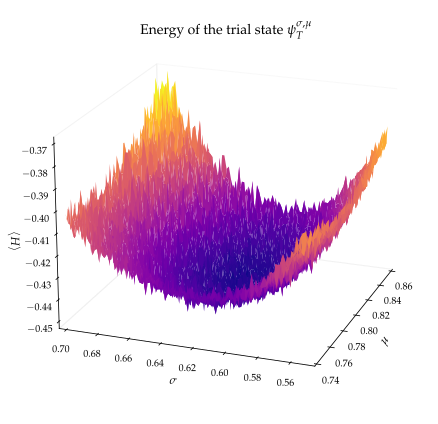

In [3]:
energies = np.loadtxt(results_directory + "minimization_energy.dat")
steps = 100
shape = (steps, steps)

mu = np.reshape(energies[:,0], shape)
sigma = np.reshape(energies[:,1], shape)
e = np.reshape(energies[:,2], shape)

fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(mu, sigma, e, cmap='plasma')
ax.set_title('Energy of the trial state $\psi_T^{\sigma, \mu}$')
settings_3d(ax, labels=['$\mu$', '$\sigma$', '$\\langle H \\rangle$'])
ax.view_init(20, -160)

#ax2 = fig.add_subplot(122, projection='3d')
#ax2.plot_surface(mu, sigma, e, cmap='plasma')
#ax2.set_title('$\sigma$ - view')
#settings_3d(ax2, labels=['$\mu$', '$\sigma$', '$\\langle H \\rangle$'])
#ax2.view_init(10, 10)

In [4]:
index_emin = np.argmin(energies[:,2])
mu_opt, sigma_opt = energies[index_emin, 0], energies[index_emin, 1]
mu_opt, sigma_opt

(0.812727, 0.633333)

## Exercise 8.2

Use your Variational Monte Carlo code to find the parameters $\sigma$ and $\mu$ which minimize $\langle {\hat H} \rangle_T$:

$$
\langle {\hat H} \rangle_T = \frac{\langle \psi_T^{\sigma,\mu}| {\hat H} | \psi_T^{\sigma,\mu} \rangle}
{\langle \psi_T^{\sigma,\mu} | \psi_T^{\sigma,\mu} \rangle} \ge E_0 =
\frac{\langle \psi_0| {\hat H} | \psi_0 \rangle}
{\langle \psi_0 | \psi_0 \rangle}
$$

<p class="assignement"> Plot the estimation of $\langle {\hat H} \rangle_T$ and its statistical uncertainty as a function of the number of blocks (/MC steps) for the set of parameters which minimize $\langle {\hat H} \rangle_T$. Also plot the <b>sampled</b> $|\psi_T(x)|^2$ by filling a histogram with the sampled configurations, and compare it with both the <b>analytic curve</b> of $|\psi_T(x)|^2$ and the <b>numerical solution</b> obtained by transforming the Schrödinger equation into a matrix equation (see below the supplementary material).

Ground state energy:  -0.46046587969271535
1st excited state energy:  0.0974247133176099
2nd excited state energy:  1.9717331343930198
0.423486


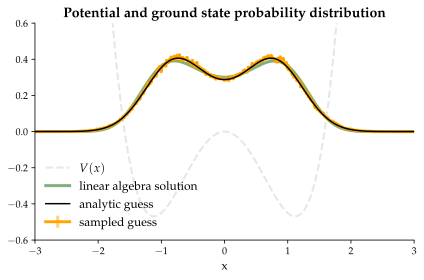

In [5]:
#mu_opt = 0.812727
#sigma_opt = 0.633333

def potential(x):
    return (x**2 - 2.5)*x**2

def psi_analytic(x):
    normalization = 2 * np.sqrt(np.pi) * sigma_opt * (1 + np.exp(-(mu_opt/sigma_opt)**2))
    plus = (mu_opt + x) / sigma_opt
    minus = (mu_opt - x) / sigma_opt
    return (np.exp(-0.5 * plus**2) + np.exp(-0.5 * minus**2)) / np.sqrt(normalization)

# simplified units
hbar = 1
m = 1

# x range to represent
span = 10
npoints = 1000
x = np.linspace(-span/2, span/2, npoints)
dx = x[1] - x[0] # step size

V = potential(x)

# central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2
cdiff_matrix = np.diag(np.ones(npoints-1), -1) - 2 * np.diag(np.ones(npoints)) + np.diag(np.ones(npoints-1), 1)

# Hamiltonian matrix (hbar = 1, m = 1)
H = - 0.5 * cdiff_matrix / (dx**2) + np.diag(V)

# compute eigenvalues (E) and eigenvectors (psi) assuming H is hermitian
E, psi = np.linalg.eigh(H)

# transpose and normalize
psi = psi.T / np.sqrt(dx)

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

psi_histo = np.loadtxt(results_directory + 'psi_sampled.dat')
print(max(psi_histo[:,1]))

# plots
fig, ax = plt.subplots()
scale = 0.3
ax.plot(x, scale * V, c="k", alpha=0.1, ls='--', label="$V(x)$")
ax.plot(x, psi[0] ** 2, lw=3, alpha=0.5, c='darkgreen', label="linear algebra solution")
#plt.plot(x, psi[1] ** 2, alpha=0.5, label="$|\psi_1(x)|^2$")
#plt.plot(x, psi[2] ** 2, alpha=0.3, label="$|\psi_2(x)|^2$")
set_labels(ax, "Potential and ground state probability distribution", 'x')
ax.set_xlim((-3,3))
ax.set_ylim((-0.6,0.6))
markers, caps, bars = ax.errorbar(psi_histo[:,0], psi_histo[:,1], yerr=psi_histo[:,2], lw=3, c='orange', label='sampled guess', zorder=2)
[bar.set_alpha(0.5) for bar in bars]
ax.plot(x, psi_analytic(x)**2, c='k', lw=1.5, label='analytic guess', zorder=3)
ax.legend();

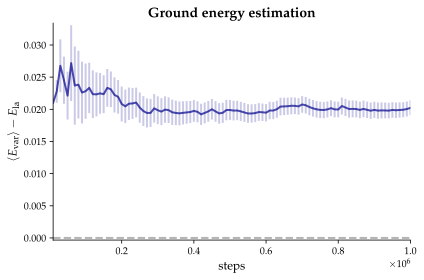

In [6]:
fig, ax = plt.subplots()
set_labels(ax, 'Ground energy estimation', 'steps', '$\\langle E_{\\rm var}\\rangle - E_{\\rm la}$')
filename = results_directory + 'ground_energy.dat'
estimation_plot(ax, filename, expected_y=E[0])

The variational method **overestimates** the ground energy by a little bit, and the naive method used for finding the minimum does not guarantee that we found the best possible wave function in the family chosen.

## Exercise 8.3

Use the PIMC/PIGS code we have provided to study the same 1D quantum system. Use the PIGS algorithm ($T=0$) to project
- a constant trial wave function, $\psi_T(x)\equiv1$
- using $\psi_T(x) = \psi_T^{\sigma,\mu}(x)$ with the variational parameters you have optimized.

<p class="assignement">Compare your results with those obtained with your VMC code.</p>
    
<p class="remark">By using $\psi_T^{\sigma,\mu}(x)$, how much can you reduce the imaginary time propagation with respect to the first case?

<p class="assignement"> Use the PIMC algorithm $(T>0)$ to observe how the histogram with the sampled configurations changes when increasing the temperature.

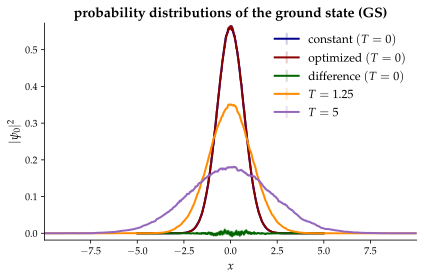

In [7]:
results_mc = '../lab_08/QMC_1D/'
proba_const = np.loadtxt(results_mc + 'probability_const.dat')
proba_psi = np.loadtxt(results_mc + 'probability_psi.dat')

fig, ax = plt.subplots()
set_labels(ax, 'probability distributions of the ground state (GS)', '$x$', '$|\psi_0|^2$')

markers, caps, bars = ax.errorbar(proba_const[:,0], proba_const[:,1], yerr=proba_const[:,2], label='constant $(T=0)$')
[bar.set_alpha(0.2) for bar in bars]
markers, caps, bars = ax.errorbar(proba_psi[:,0], proba_psi[:,1], yerr=proba_psi[:,2], label='optimized $(T=0)$')
[bar.set_alpha(0.2) for bar in bars]
markers, caps, bars = ax.errorbar(proba_const[:,0], proba_const[:,1] - proba_psi[:,1], 
                                  yerr=proba_const[:,2] + proba_psi[:,2], label='difference $(T=0)$')
[bar.set_alpha(0.2) for bar in bars]

for T in [1.25, 5]:
    temp = str(T)
    proba = np.loadtxt(results_mc + 'probability_' + temp + '.dat')
    markers, caps, bars = ax.errorbar(proba[:,0], proba[:,1], yerr=proba[:,2], label=f'$T = {T}$')
    [bar.set_alpha(0.2) for bar in bars]

ax.legend();

It broadens!

### <span style="color:green">Supplementary material</span>

How can we describe a wave function as a vector? We set up a lattice of discrete points, spaced by a constant distance $dx$, and record the value of the function at each lattice point. In this way the wave function, $\Psi(x)$ become a vector:

$$
\Psi(x) \to \left[ \Psi(x_1), \Psi(x_2), ..., \Psi(x_N) \right] = 
\left[ \Psi_1, \Psi_2, ..., \Psi_N \right]
$$

The time independent Schrodinger equation 

$$
{\hat H} \Psi(x) = \left( -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + V(x) \right) \Psi(x) = E \Psi(x)
$$

can be written in matrix form. But how do we write the second derivative at a particular point? Let's start with the first derivatives:
$$
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) \simeq \frac{\Psi_{i+1}-\Psi_{i}}{dx}\\
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right) \simeq \frac{\Psi_{i}-\Psi_{i-1}}{dx}
$$

Thus, we can discretize the second derivative in the following way:
$$
\frac{\partial^2}{\partial x^2} \Psi(x=x_i) =
\frac{\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) - \frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right)}{dx} =
\frac{\Psi_{i+1}-2\Psi_{i}+\Psi_{i-1}}{dx^2}
$$

We finally obtain:

$$
\begin{bmatrix}
 \frac{\hbar^2}{m\,dx^2}+V(x_1)& -\frac{\hbar^2}{2m\,dx^2} & 0 & \dots  & 0 \\
-\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_2) & -\frac{\hbar^2}{2m\,dx^2} & \dots  & 0 \\
 0                        & -\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_3) & \dots  & 0 \\
 \vdots                   & \vdots                    & \vdots & \ddots & \vdots \\
 0                    & 0                & 0 & \dots  & \frac{\hbar^2}{m\,dx^2}+V(x_N)
\end{bmatrix}
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
= E
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
$$

To solve the time independent Schrodinger equation we therefore have to find eigenstates and eigenvalues of the matrix just obtained.